<a href="https://colab.research.google.com/github/fab311111/Attrition_Prediction/blob/main/Trained%20model%20for%20attrition%2009%20Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# plt.rcParams['font.family'] = 'Inter' # Removed line

In [ ]:
# ==============================================================================
# PHASE 1: Data Understanding and Cleaning
# ==============================================================================

# 1. Load Data
try:
    # Use the content of the attached CSV file for the DataFrame
    # Note: In a real environment, you would use a direct file path.
    df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    print("Data loaded successfully. Shape:", df.shape)
    # Create a copy for initial exploratory data analysis (EDA) before any transformations
    df_eda = df.copy()
except Exception as e:
    print(f"Error loading file: {e}")
    # Exit or handle error if file loading fails
    exit()

Data loaded successfully. Shape: (1470, 35)


In [ ]:
# 2. Target Variable Conversion
# Convert 'Attrition' (target variable) from 'Yes'/'No' to 1/0
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])
print("\nTarget Variable 'Attrition' converted to numerical (1=Yes, 0=No).")



Target Variable 'Attrition' converted to numerical (1=Yes, 0=No).


In [ ]:
# 3. Feature Elimination
# Drop irrelevant/constant columns
columns_to_drop = [
    'EmployeeCount',    # All values are 1
    'StandardHours',    # All values are 80
    'Over18',           # All values are 'Y'
    'EmployeeNumber'    # Unique ID, no predictive value
]
df = df.drop(columns=columns_to_drop)
print("Irrelevant columns dropped.")


Irrelevant columns dropped.


In [ ]:

# ==============================================================================
# PHASE 2: Data Preprocessing for Model
# ==============================================================================

# Identify feature types
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.drop('Attrition')

# 1. One-Hot Encoding for Nominal Categorical Features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2. Separate Features (X) and Target (y)
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 3. Numerical Feature Scaling
numerical_features_after_encoding = X.columns[X.columns.isin(numerical_cols)]
scaler = StandardScaler()
X[numerical_features_after_encoding] = scaler.fit_transform(X[numerical_features_after_encoding])

# 4. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



In [ ]:

# ==============================================================================
# PHASE 3: Model Training
# ==============================================================================

# Using Random Forest Classifier with balanced class weight
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [ ]:

# ==============================================================================
# PHASE 4: Model Evaluation and Interpretation
# ==============================================================================

# 1. Prediction
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 2. Performance Metrics
print("\n--- Model Evaluation (Random Forest Classifier) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report (Focus on Recall for '1' (Attrition) class):")
print(classification_report(y_test, y_pred))

# 3. Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- Top 10 Feature Importances ---")
print(top_10_features.to_markdown(numalign="left", stralign="left"))



--- Model Evaluation (Random Forest Classifier) ---
Accuracy: 0.8451

Classification Report (Focus on Recall for '1' (Attrition) class):
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       309
           1       0.60      0.10      0.17        59

    accuracy                           0.85       368
   macro avg       0.73      0.54      0.54       368
weighted avg       0.81      0.85      0.80       368


--- Top 10 Feature Importances ---
|                      | 0         |
|:---------------------|:----------|
| MonthlyIncome        | 0.0725922 |
| Age                  | 0.0690494 |
| DailyRate            | 0.0541678 |
| YearsAtCompany       | 0.0529591 |
| OverTime_Yes         | 0.0481096 |
| YearsWithCurrManager | 0.0470249 |
| TotalWorkingYears    | 0.0465274 |
| HourlyRate           | 0.0439225 |
| MonthlyRate          | 0.0432158 |
| DistanceFromHome     | 0.0415915 |



--- Generating Visualization 1: Attrition Rate by Department ---


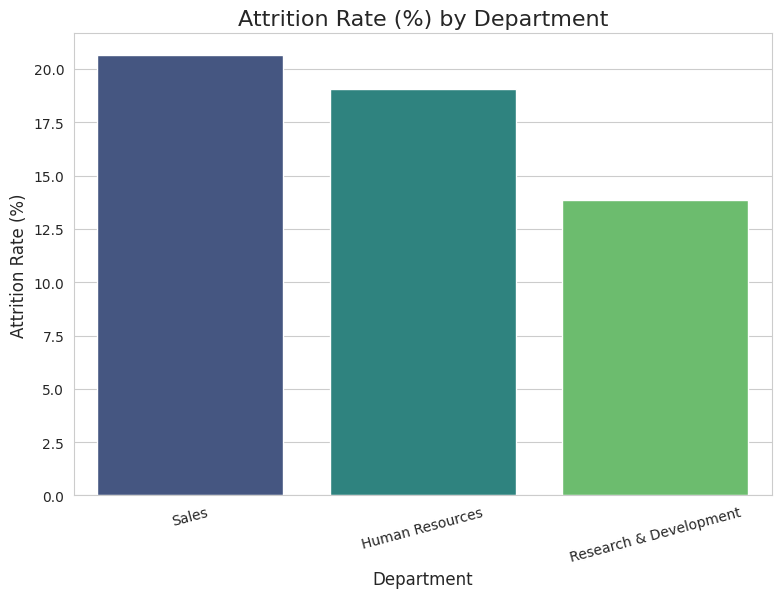

In [ ]:
# ==============================================================================
# VISUALIZATION 1: Attrition Rate by Department
# ==============================================================================
print("\n--- Generating Visualization 1: Attrition Rate by Department ---")
attrition_by_dept = df_eda.groupby('Department')['Attrition'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
attrition_yes = attrition_by_dept[attrition_by_dept['Attrition'] == 'Yes'].sort_values('Percent', ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(x='Department', y='Percent', data=attrition_yes, hue='Department', palette='viridis', legend=False)
plt.title('Attrition Rate (%) by Department', fontsize=16)
plt.ylabel('Attrition Rate (%)', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation=15)
plt.show()


--- Generating Visualization 2: Monthly Income Distribution vs. Attrition ---


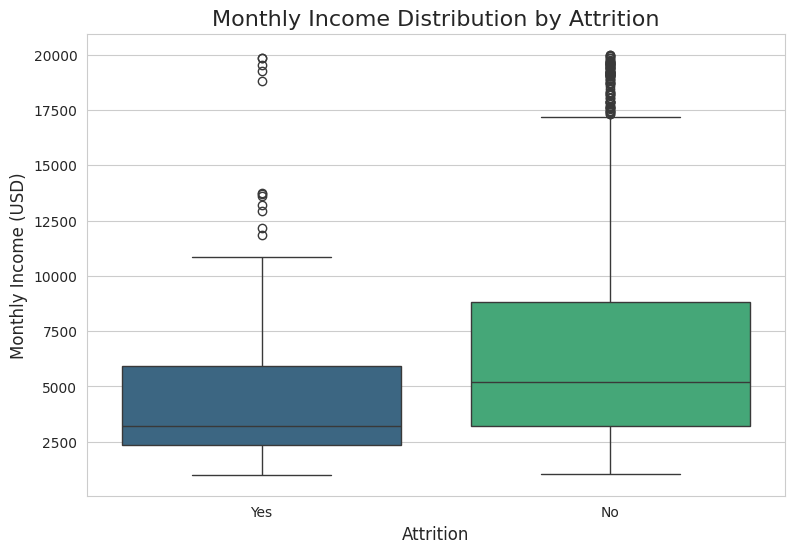

In [ ]:
# ==============================================================================
# VISUALIZATION 2: Monthly Income Distribution vs. Attrition
# ==============================================================================
print("\n--- Generating Visualization 2: Monthly Income Distribution vs. Attrition ---")
plt.figure(figsize=(9, 6))
# Rename labels for better plotting clarity in the EDA copy
# Re-create df_eda from the original df (assuming df_eda was modified in previous steps)
df_eda = df.copy()
df_eda['Attrition_Label'] = df_eda['Attrition'].map({1: 'Yes', 0: 'No'})


sns.boxplot(data=df_eda, x='Attrition_Label', y='MonthlyIncome', hue='Attrition_Label', palette='viridis')
plt.title('Monthly Income Distribution by Attrition', fontsize=16)
plt.xlabel('Attrition', fontsize=12)
plt.ylabel('Monthly Income (USD)', fontsize=12)
plt.show()


--- Generating Visualization 3: Top 10 Feature Importances ---


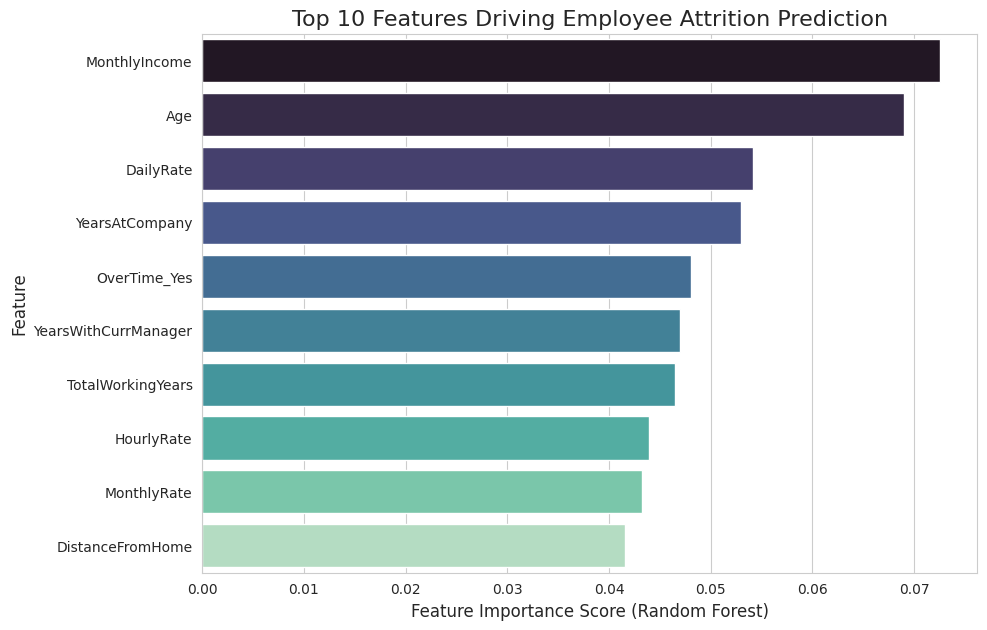


All model training steps and visualizations are complete.


In [ ]:
# ==============================================================================
# VISUALIZATION 3: Top 10 Feature Importances Bar Chart
# ==============================================================================
print("\n--- Generating Visualization 3: Top 10 Feature Importances ---")
plt.figure(figsize=(10, 7))
sns.barplot(x=top_10_features.values, y=top_10_features.index, hue=top_10_features.index, palette="mako", legend=False)
plt.title('Top 10 Features Driving Employee Attrition Prediction', fontsize=16)
plt.xlabel('Feature Importance Score (Random Forest)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

print("\nAll model training steps and visualizations are complete.")

In [17]:
# Phase 5: Refine the model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

# Define the parameter grid to tune
# Focus on parameters that can influence the model's ability to capture the minority class
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Define the scoring metric: focus on recall for the positive class (1)
recall_scorer = make_scorer(recall_score, pos_label=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=recall_scorer, cv=3, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
print("\n--- Starting GridSearchCV for Hyperparameter Tuning ---")
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print("\n--- GridSearchCV Results ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best recall score on validation sets: {grid_search.best_score_:.4f}")

# Train the final model with the best parameters
best_rf_model = grid_search.best_estimator_
print("\n--- Training final model with best parameters ---")
best_rf_model.fit(X_train, y_train)
print("Final model trained.")


--- Starting GridSearchCV for Hyperparameter Tuning ---
Fitting 3 folds for each of 216 candidates, totalling 648 fits

--- GridSearchCV Results ---
Best parameters found: {'class_weight': 'balanced_subsample', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best recall score on validation sets: 0.4665

--- Training final model with best parameters ---
Final model trained.


In [18]:
# ==============================================================================
# PHASE 6: Evaluate Refined Model
# ==============================================================================

print("\n--- Evaluating Refined Model (Random Forest Classifier with Best Parameters) ---")

# Predict using the best model found by GridSearchCV
y_pred_refined = best_rf_model.predict(X_test)
y_pred_proba_refined = best_rf_model.predict_proba(X_test)[:, 1]

# Performance Metrics for the refined model
print(f"Accuracy (Refined Model): {accuracy_score(y_test, y_pred_refined):.4f}")
print("\nClassification Report (Refined Model - Focus on Recall for '1' (Attrition) class):")
print(classification_report(y_test, y_pred_refined))

# Optional: Compare with the initial model's performance
# print("\n--- Comparison with Initial Model ---")
# print("Initial Model Recall (Attrition=1):", classification_report(y_test, y_pred)['recall'][1])
# print("Refined Model Recall (Attrition=1):", classification_report(y_test, y_pred_refined)['recall'][1])

# 3. Feature Importance for the refined model (Optional - usually similar but can vary slightly)
# feature_importances_refined = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
# top_10_features_refined = feature_importances_refined.nlargest(10)
# print("\n--- Top 10 Feature Importances (Refined Model) ---")
# print(top_10_features_refined.to_markdown(numalign="left", stralign="left"))


--- Evaluating Refined Model (Random Forest Classifier with Best Parameters) ---
Accuracy (Refined Model): 0.8315

Classification Report (Refined Model - Focus on Recall for '1' (Attrition) class):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       309
           1       0.47      0.46      0.47        59

    accuracy                           0.83       368
   macro avg       0.69      0.68      0.68       368
weighted avg       0.83      0.83      0.83       368




--- Generating Visualization 4: Attrition Rate by Age Group ---


/tmp/ipython-input-2746982323.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_by_age = df_eda.groupby('AgeGroup')['Attrition_Label'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()


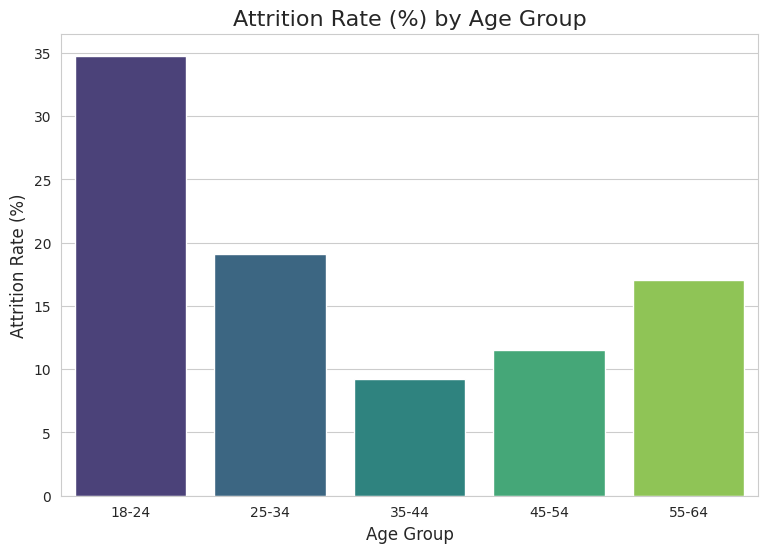

In [12]:
# ==============================================================================
# VISUALIZATION 4: Attrition Rate by Age Group
# ==============================================================================
print("\n--- Generating Visualization 4: Attrition Rate by Age Group ---")

# Create age groups
df_eda['AgeGroup'] = pd.cut(df_eda['Age'], bins=[18, 25, 35, 45, 55, 65], labels=['18-24', '25-34', '35-44', '45-54', '55-64'])

# Calculate attrition rate by age group
attrition_by_age = df_eda.groupby('AgeGroup')['Attrition_Label'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
attrition_by_age_yes = attrition_by_age[attrition_by_age['Attrition_Label'] == 'Yes'].sort_values('AgeGroup')

plt.figure(figsize=(9, 6))
sns.barplot(x='AgeGroup', y='Percent', data=attrition_by_age_yes, hue='AgeGroup', palette='viridis', legend=False)
plt.title('Attrition Rate (%) by Age Group', fontsize=16)
plt.ylabel('Attrition Rate (%)', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.show()


--- Generating Visualization 5: Attrition Rate by Years at Company ---


/tmp/ipython-input-3387351520.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_by_years = df_eda.groupby('YearsAtCompanyGroup')['Attrition_Label'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()


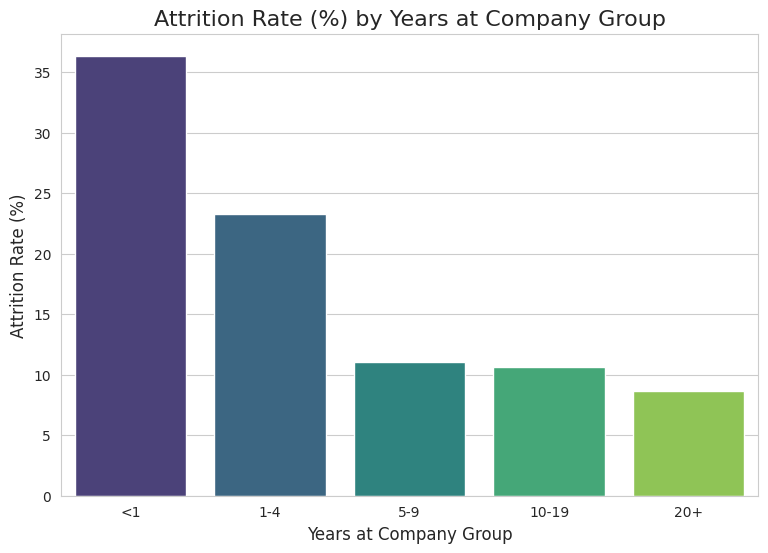

In [13]:
# ==============================================================================
# VISUALIZATION 5: Attrition Rate by Years at Company
# ==============================================================================
print("\n--- Generating Visualization 5: Attrition Rate by Years at Company ---")

# Create years at company groups
df_eda['YearsAtCompanyGroup'] = pd.cut(df_eda['YearsAtCompany'], bins=[0, 1, 5, 10, 20, 40], labels=['<1', '1-4', '5-9', '10-19', '20+'], right=False)

# Calculate attrition rate by years at company group
attrition_by_years = df_eda.groupby('YearsAtCompanyGroup')['Attrition_Label'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
attrition_by_years_yes = attrition_by_years[attrition_by_years['Attrition_Label'] == 'Yes'].sort_values('YearsAtCompanyGroup')

plt.figure(figsize=(9, 6))
sns.barplot(x='YearsAtCompanyGroup', y='Percent', data=attrition_by_years_yes, hue='YearsAtCompanyGroup', palette='viridis', legend=False)
plt.title('Attrition Rate (%) by Years at Company Group', fontsize=16)
plt.ylabel('Attrition Rate (%)', fontsize=12)
plt.xlabel('Years at Company Group', fontsize=12)
plt.show()


--- Generating Visualization 6: Attrition by Age, Monthly Income, and Years at Company ---


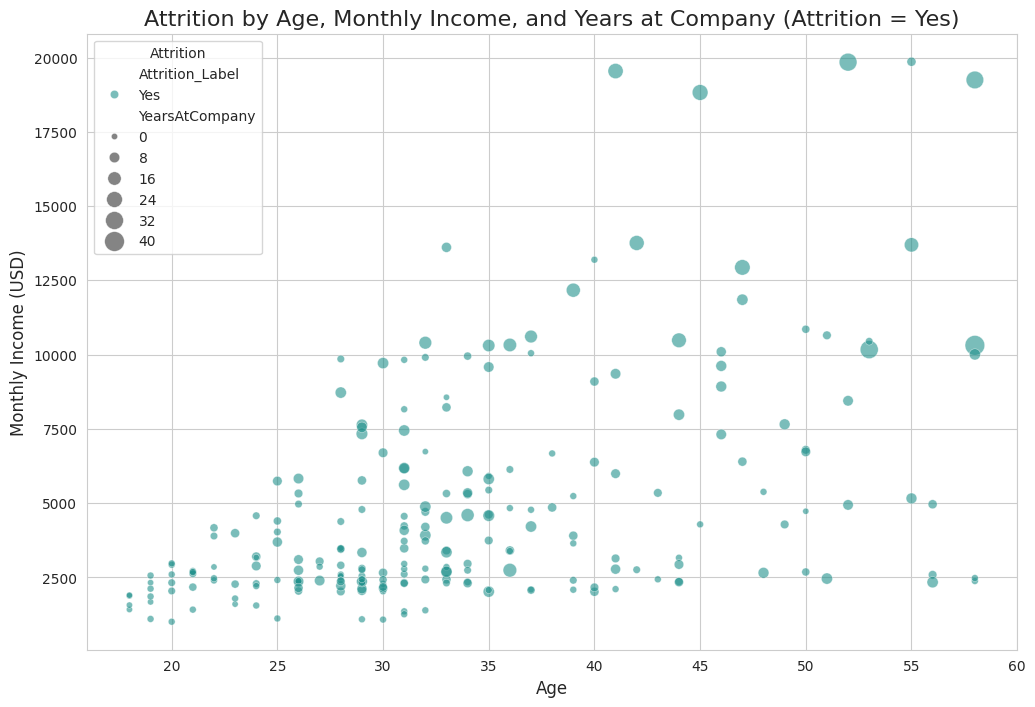

In [14]:
# ==============================================================================
# VISUALIZATION 6: Attrition by Age, Monthly Income, and Years at Company
# ==============================================================================
print("\n--- Generating Visualization 6: Attrition by Age, Monthly Income, and Years at Company ---")

# Filter data to show only attrition=Yes
df_attrition_yes = df_eda[df_eda['Attrition_Label'] == 'Yes'].copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_attrition_yes, x='Age', y='MonthlyIncome', size='YearsAtCompany', hue='Attrition_Label', palette='viridis', alpha=0.6, sizes=(20, 200))
plt.title('Attrition by Age, Monthly Income, and Years at Company (Attrition = Yes)', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Monthly Income (USD)', fontsize=12)
plt.legend(title='Attrition')
plt.grid(True)
plt.show()

In [15]:
# 1. Create a new DataFrame called high_risk_employees
high_risk_employees = df_eda[df_eda['Attrition'] == 1].copy()

# 2. Print descriptive statistics for numerical columns
print("\n--- Descriptive Statistics for High-Risk Employees (Numerical Features) ---")
display(high_risk_employees.describe())

# 3. Print value counts for key categorical columns
print("\n--- Value Counts for High-Risk Employees (Categorical Features) ---")
categorical_cols_to_examine = ['Department', 'JobRole', 'MaritalStatus_Single', 'OverTime_Yes'] # Include dummy variable names
for col in categorical_cols_to_examine:
    if col in high_risk_employees.columns:
        print(f"\nValue Counts for '{col}':")
        display(high_risk_employees[col].value_counts())


--- Descriptive Statistics for High-Risk Employees (Numerical Features) ---


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,237.000000,237.0,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,...,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,33.607595,1.0,750.362869,10.632911,2.839662,2.464135,65.573840,2.518987,1.637131,2.468354,...,3.156118,2.599156,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321
std,9.689350,0.0,401.899519,8.452525,1.008244,1.169791,20.099958,0.773405,0.940594,1.118058,...,0.363735,1.125437,0.856361,7.169204,1.254784,0.816453,5.949984,3.174827,3.153077,3.143349
min,18.000000,1.0,103.000000,1.000000,1.000000,1.000000,31.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.0,408.000000,3.000000,2.000000,1.000000,50.000000,2.000000,1.000000,1.000000,...,3.000000,2.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,32.000000,1.0,699.000000,9.000000,3.000000,3.000000,66.000000,3.000000,1.000000,3.000000,...,3.000000,3.000000,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,39.000000,1.0,1092.000000,17.000000,4.000000,4.000000,84.000000,3.000000,2.000000,3.000000,...,3.000000,4.000000,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000
max,58.000000,1.0,1496.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,15.000000,15.000000,14.000000



--- Value Counts for High-Risk Employees (Categorical Features) ---

Value Counts for 'MaritalStatus_Single':


,count
MaritalStatus_Single,
True,120
False,117



Value Counts for 'OverTime_Yes':


,count
OverTime_Yes,
True,127
False,110



--- Visualizing Key Numerical Features for High-Risk Employees ---


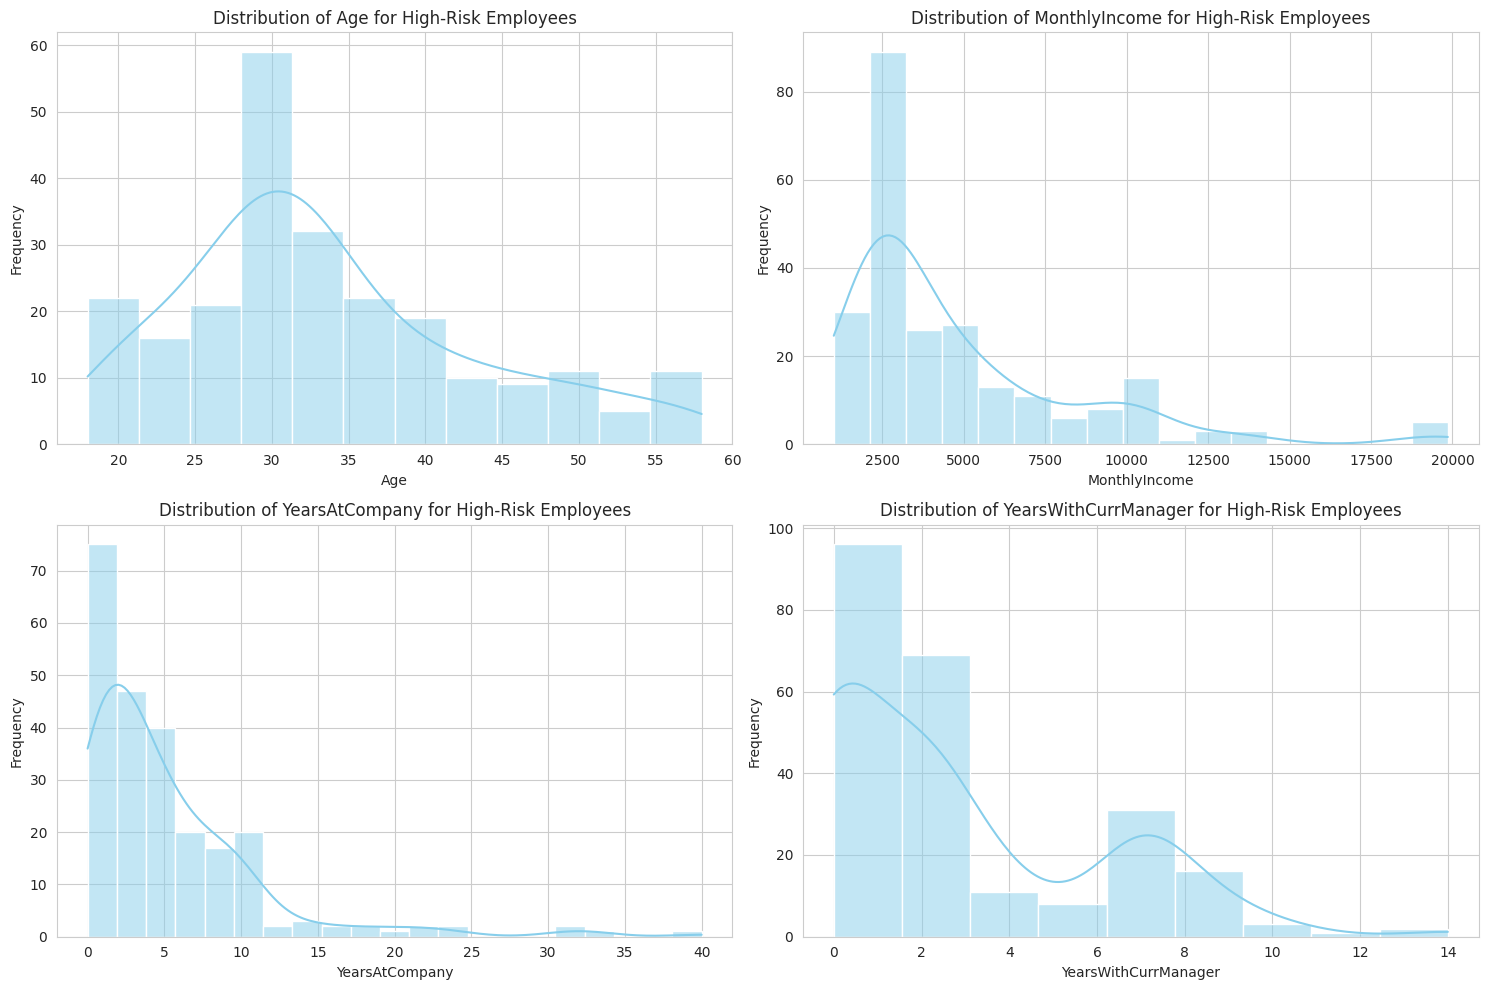


--- Visualizing Key Categorical Features for High-Risk Employees ---


/tmp/ipython-input-1365341986.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_risk_employees, y=col, order=high_risk_employees[col].value_counts().index, ax=axes[i], palette='viridis')
/tmp/ipython-input-1365341986.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_risk_employees, y=col, order=high_risk_employees[col].value_counts().index, ax=axes[i], palette='viridis')


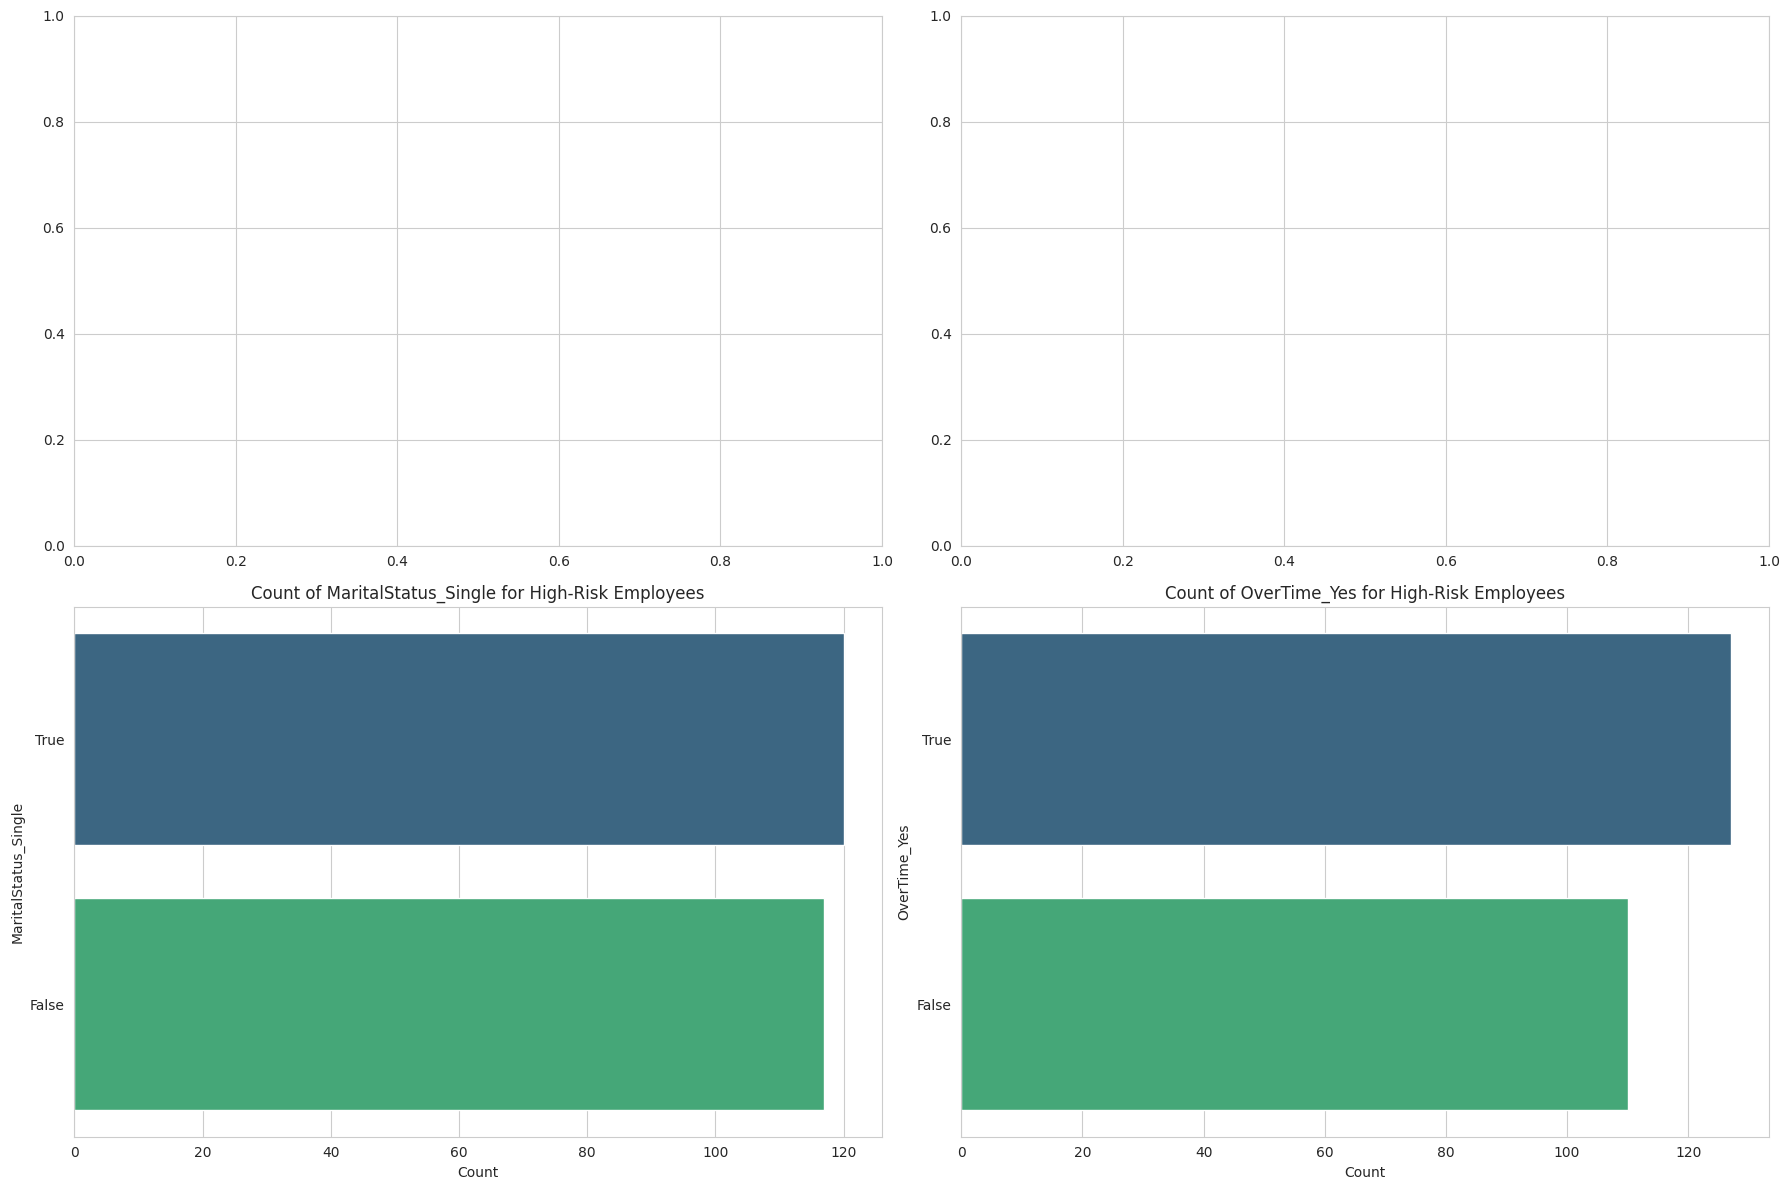

In [16]:
# 4. Generate histograms or box plots for numerical features
print("\n--- Visualizing Key Numerical Features for High-Risk Employees ---")
numerical_features_to_plot = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'YearsWithCurrManager']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features_to_plot):
    sns.histplot(data=high_risk_employees, x=col, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col} for High-Risk Employees')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# 5. Generate bar plots for key categorical features
print("\n--- Visualizing Key Categorical Features for High-Risk Employees ---")
categorical_features_to_plot = ['Department', 'JobRole', 'MaritalStatus_Single', 'OverTime_Yes']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_features_to_plot):
    if col in high_risk_employees.columns:
        sns.countplot(data=high_risk_employees, y=col, order=high_risk_employees[col].value_counts().index, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Count of {col} for High-Risk Employees')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

## Refine model

### Subtask:
Based on the analysis of high-risk employees and the previous model evaluation (which showed lower recall for the '1' class), explore ways to improve the model's performance, particularly in identifying employees likely to attrite. This might involve trying different models, tuning hyperparameters, or addressing class imbalance further.


**Reasoning**:
The previous model evaluation showed a low recall for the minority class (attrition = 1), indicating the model is not good at identifying employees who will attrite. The analysis of high-risk employees confirmed that certain employee segments are more prone to attrition. To improve the model's ability to predict attrition, we need to either refine the existing model by tuning hyperparameters or train a new model more suited for imbalanced datasets. Given that the current RandomForestClassifier has a class_weight='balanced' parameter, let's first attempt hyperparameter tuning on this model to optimize for recall. We will use GridSearchCV to find the best parameters.



Refining the model